<a href="https://colab.research.google.com/github/Sayak007/Covid-19-Forecast-Model/blob/master/Peak_Data_analysis_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
# to parse json contents
import json
# to parse csv files
import csv

# for numerical operations
import numpy as np
# to store and analysis data in dataframes
import pandas as pd

from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import preprocessing, svm
## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
dateparse = lambda dates: datetime.strptime(str(dates)+"2020", '%d %B %Y')
cov = pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv',parse_dates=['Date'],index_col=['Date'],date_parser=dateparse)
cov.to_csv('nation_level_daily.csv')
cov.tail()

,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
Date,,,,,,
2020-06-17,13108,367269,6890,194440,341,12263
2020-06-18,13829,381098,10741,205181,343,12606
2020-06-19,14740,395838,9029,214210,364,12970
2020-06-20,15918,411753,13974,228184,308,13278
2020-06-21,15158,426911,9069,237253,426,13704


In [3]:
cov2 = cov[['Total Confirmed', 'Daily Confirmed']].copy()
#cov3=cov2.rename(columns={'total':'Total Confirmed','new':'Daily Confirmed'})
cov2.tail()

,Total Confirmed,Daily Confirmed
Date,,
2020-06-17,367269,13108
2020-06-18,381098,13829
2020-06-19,395838,14740
2020-06-20,411753,15918
2020-06-21,426911,15158


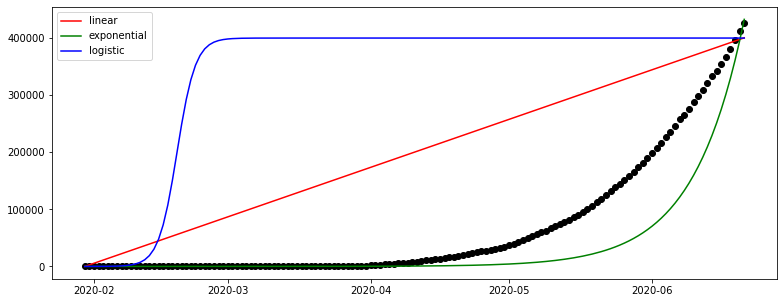

In [4]:
'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 10 + 2800*x

y_linear = f(x=np.arange(len(cov2)))
'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 10 + 1.095**x

y_exponential = f(x=np.arange(len(cov2)))
'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''
def f(x): 
    return 400000 / (1 + np.exp(-0.5*(x-20)))

y_logistic = f(x=np.arange(len(cov2)))

fig, ax = plt.subplots(figsize=(13,5))
ax.scatter(cov2["Total Confirmed"].index, cov2["Total Confirmed"].values, color="black")
ax.plot(cov2["Total Confirmed"].index, y_linear, label="linear", color="red")
ax.plot(cov2["Total Confirmed"].index, y_exponential, label="exponential", color="green")
ax.plot(cov2["Total Confirmed"].index, y_logistic, label="logistic", color="blue")
ax.legend()
plt.show()

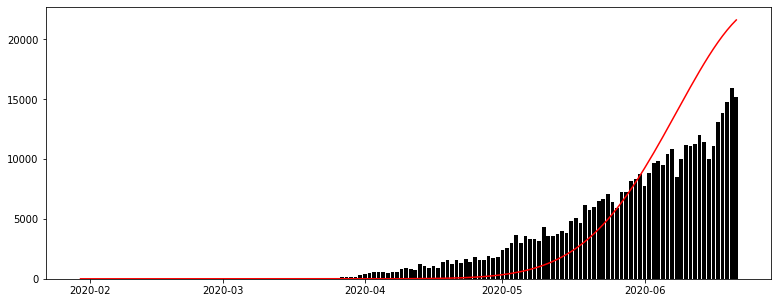

In [5]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(x):
    return 23000 * np.exp(-0.02 * ((x-150)/4)**2)

y_gaussian = f(x=np.arange(len(cov2)))

fig, ax = plt.subplots(figsize=(13,5))
ax.bar(cov2["Daily Confirmed"].index, cov2["Daily Confirmed"].values, color="black")
ax.plot(cov2["Daily Confirmed"].index, y_gaussian, color="red")
plt.show()

In [6]:
'''
Logistic function: f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
from scipy import optimize
def logistic_f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y
## optimize from scipy
logistic_model, cov = optimize.curve_fit(logistic_f,np.arange(len(cov2["Total Confirmed"])),cov2["Total Confirmed"].values, maxfev=10000,p0=[np.max(cov2["Total Confirmed"]), 1, 1])
## print the parameters
logistic_model

array([7.70148648e+05, 6.11792746e-02, 1.40246972e+02])

In [7]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def gaussian_f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y
## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,np.arange(len(cov2["Daily Confirmed"])), cov2["Daily Confirmed"].values, maxfev=10000,p0=[1, np.mean(cov2["Daily Confirmed"]), np.std(cov2["Daily Confirmed"])])
## print the parameters
gaussian_model

array([22601.82885084,   184.39588789,    43.63552041])

In [8]:
'''
Plot parametric fitting.
'''
def utils_plot_parametric(dtf, zoom=30, figsize=(15,5)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    ## entire series
    dtf["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
    dtf["model"].plot(ax=ax[0], color="green")
    dtf["forecast"].plot(ax=ax[0], grid=True, color="red")
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)
   
    ## focus on last
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    dtf.loc[zoom_idx:]["ts"].plot(marker=".", linestyle='None', ax=ax[1], color="black", 
                                  title="Zoom on the last "+str(zoom)+" observations")
    dtf.loc[zoom_idx:]["model"].plot(ax=ax[1], color="green")
    dtf.loc[zoom_idx:]["forecast"].plot(ax=ax[1], grid=True, color="red")
    ax[1].fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['conf_int_low'], 
                       y2=dtf.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

In [15]:
'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param f: function
    :param model: list of optim params
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param freq: None or str - 'B' business day, 'D' daily, 'W' weekly, 'M' monthly, 'A' annual, 'Q' quarterly
    :param zoom: for plotting
'''
def forecast_curve(ts, f, model, pred_ahead=None, freq="D", zoom=30, figsize=(15,5)):
    ## fit
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    
    ## index
    index = pd.date_range(start=cov2.index[-1],periods=pred_ahead,freq=freq)
    index = index[1:]
    ## forecast
    Xnew = np.arange(len(ts)+1, len(ts)+1+len(index))
    preds = f(Xnew, model[0], model[1], model[2])
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## plot
    utils_plot_parametric(dtf, zoom=zoom)
    return dtf

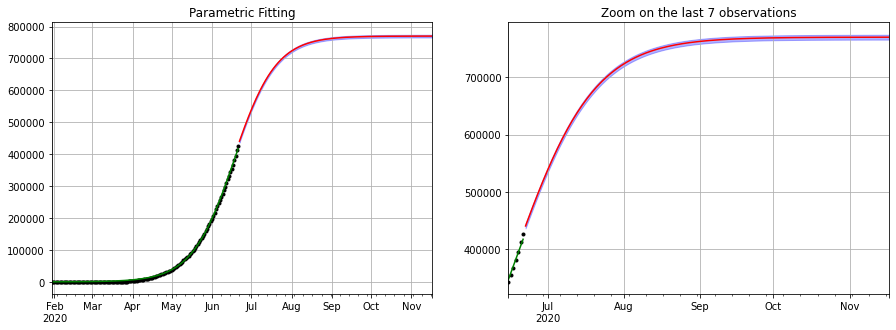

In [16]:
preds = forecast_curve(cov2["Total Confirmed"], logistic_f, logistic_model, pred_ahead=150, freq="D", zoom=7)

In [18]:
preds.tail(150)

,ts,model,forecast,residuals,conf_int_low,conf_int_up
2020-06-21,426911.0,417426.576239,NaN,9484.423761,NaN,NaN
2020-06-22,NaN,NaN,440670.386966,NaN,436415.211142,444925.562790
2020-06-23,NaN,NaN,452149.854488,NaN,447894.678664,456405.030312
2020-06-24,NaN,NaN,463507.674571,NaN,459252.498747,467762.850395
2020-06-25,NaN,NaN,474724.882326,NaN,470469.706502,478980.058150
...,...,...,...,...,...,...
2020-11-13,NaN,NaN,770062.710212,NaN,765807.534388,774317.886036
2020-11-14,NaN,NaN,770067.809696,NaN,765812.633872,774322.985521
2020-11-15,NaN,NaN,770072.606611,NaN,765817.430787,774327.782436
2020-11-16,NaN,NaN,770077.118906,NaN,765821.943082,774332.294730


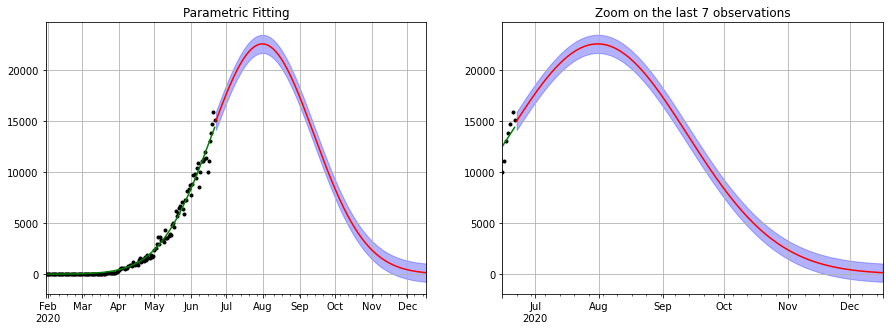

In [19]:
preds = forecast_curve(cov2["Daily Confirmed"], gaussian_f, gaussian_model, pred_ahead=180, freq="D", zoom=7)

In [23]:
preds.tail(180)

,ts,model,forecast,residuals,conf_int_low,conf_int_up
2020-06-21,15158.0,14411.68816,NaN,746.31184,NaN,NaN
2020-06-22,NaN,NaN,15036.354522,NaN,14137.071193,15935.637852
2020-06-23,NaN,NaN,15346.674215,NaN,14447.390885,16245.957544
2020-06-24,NaN,NaN,15655.174112,NaN,14755.890782,16554.457441
2020-06-25,NaN,NaN,15961.490415,NaN,15062.207086,16860.773745
...,...,...,...,...,...,...
2020-12-13,NaN,NaN,194.024487,NaN,-705.258842,1093.307817
2020-12-14,NaN,NaN,180.734394,NaN,-718.548935,1080.017724
2020-12-15,NaN,NaN,168.266237,NaN,-731.017093,1067.549566
2020-12-16,NaN,NaN,156.575954,NaN,-742.707375,1055.859284
